# 日本語テキストデータを用いた予測
- テキストデータのトークン化
- Word2vecの実施
- 教師あり学習

参考：https://github.com/h2oai/h2o-3/blob/master/h2o-py/demos/word2vec_craigslistjobtitles.ipynb

In [41]:
import os

import pandas as pd
from janome.tokenizer import Tokenizer

In [2]:
import h2o
from h2o.estimators.word2vec import H2OWord2vecEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.__version__

'3.36.0.4'

In [3]:
df = pd.read_csv(os.path.join('..', 'data', 'amazon_reviews_JP_Books_1000SAMPLE.csv'))
df = df[['star_rating_Low','review_body2']]
print(df.shape)
df.head()

(1000, 2)


,star_rating_Low,review_body2
0,0,野球を新しい視点で見て、勝ちに繋げていった良書。ただ背伸びして洋書として購入したが、相当英語...
1,0,英語もシンプルで読みやすく、ストーリーもよかったので、楽しめました。
2,0,いまは毎日勉強していて、わかりやすく書かれていて、とても満足しています。
3,0,カワイイ、、！英語だけど写真だけで満足できる内容でした。シンメトリー、衣装、色彩などウェスア...
4,0,一般的な書店に売っていないので助かります。今後も利用したいと思います。


star_rating_Lowをターゲット、review_body2を特徴量としてモデルを作成

In [4]:
df['star_rating_Low'].value_counts()

# 評価が低いと1

0    850
1    150
Name: star_rating_Low, dtype: int64

## トークン化の実施

In [5]:
STOP_WORDS = ['・', ',', '　', '、', '。', '.', '(', ')', '（', '）', '?', '？', '●', '~', '～', '-', 'ー',  '－', '/']

tknzr = Tokenizer(wakati=True)

def tokenize_sentence(row, tknzr=tknzr):
    ''' トークン化を実施し、ストップワードを除く
    '''
    #tokened = " ".join([w for w in tknzr.tokenize(row)])
    tokened = " ".join([w for w in tknzr.tokenize(row) if w not in STOP_WORDS])
    return tokened

def token_count(row, tknzr=tknzr):
    ''' ワード数カウントを実施
    '''
    tokened_list = [w for w in tknzr.tokenize(row) if w not in STOP_WORDS]
    n_words = len(tokened_list)
    return n_words

In [6]:
# テスト
sentence = '野球を新しい視点で見て、勝ちに繋げていった良書。ただ背伸びして洋書として購入したが、相当英語に精通していないと厳しいかもしれない。'
print(tokenize_sentence(sentence))
print(token_count(sentence))

野球 を 新しい 視点 で 見 て 勝ち に 繋げ て いっ た 良書 ただ 背伸び し て 洋書 として 購入 し た が 相当 英語 に 精通 し て い ない と 厳しい かも しれ ない
37


In [7]:
%%time
# review_body2に対するトークン化
df['review_token'] = df['review_body2'].apply(tokenize_sentence)    # トークン化を実施したカラム
df['review_token_count'] = df['review_body2'].apply(token_count)   # 単語数
df.shape

CPU times: user 19.3 s, sys: 125 ms, total: 19.5 s
Wall time: 19.8 s


(1000, 4)

In [8]:
df.head()

,star_rating_Low,review_body2,review_token,review_token_count
0,0,野球を新しい視点で見て、勝ちに繋げていった良書。ただ背伸びして洋書として購入したが、相当英語...,野球 を 新しい 視点 で 見 て 勝ち に 繋げ て いっ た 良書 ただ 背伸び し て...,37
1,0,英語もシンプルで読みやすく、ストーリーもよかったので、楽しめました。,英語 も シンプル で 読み やすく ストーリー も よかっ た ので 楽しめ まし た,14
2,0,いまは毎日勉強していて、わかりやすく書かれていて、とても満足しています。,いま は 毎日 勉強 し て い て わかり やすく 書か れ て い て とても 満足 し...,21
3,0,カワイイ、、！英語だけど写真だけで満足できる内容でした。シンメトリー、衣装、色彩などウェスア...,カワイイ ！ 英語 だ けど 写真 だけ で 満足 できる 内容 でし た シンメトリー 衣...,27
4,0,一般的な書店に売っていないので助かります。今後も利用したいと思います。,一般 的 な 書店 に 売っ て い ない ので 助かり ます 今後 も 利用 し たい と...,20


,review_token_count
count,1000.000000
mean,89.324000
std,122.720697
min,8.000000
25%,25.000000
50%,46.000000
75%,101.000000
max,1131.000000


array([[<AxesSubplot:title={'center':'review_token_count'}>]],
      dtype=object)

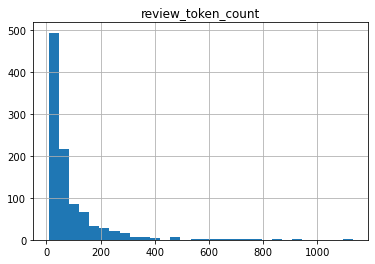

In [9]:
# ワード数の分布
display(df[['review_token_count']].describe())
df[['review_token_count']].hist(bins=30)

## Word2vec(h2o.estimators.word2vec.H2OWord2vecEstimator)の実施

Document: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/word2vec.html  
Python API: https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oword2vecestimator

In [10]:
# H2O-3の開始
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.9" 2020-10-20 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.9+7-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.9+7-LTS, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/tmp5o2lf8dx
  JVM stdout: /var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/tmp5o2lf8dx/h2o_YShimada_MBP16_started_from_python.out
  JVM stderr: /var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/tmp5o2lf8dx/h2o_YShimada_MBP16_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.4
H2O_cluster_version_age:,2 months and 21 days
H2O_cluster_name:,H2O_from_python_YShimada_MBP16_ybi6dv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [11]:
# pandas dataframeからh2oframeへの変更（H2Oクラスターへのデータのアップロード）
fm = h2o.H2OFrame(df)
fm.shape

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(1000, 4)

In [12]:
type(fm)

h2o.frame.H2OFrame

In [13]:
fm.types

{'star_rating_Low': 'int',
 'review_body2': 'string',
 'review_token': 'string',
 'review_token_count': 'int'}

In [14]:
# H2OWord2vecEstimator実施の際は、データ型をstringとする必要がある。stringとなってない場合は変更
#fm['review_token'] = fm['review_token'].ascharacter()

In [15]:
# 二値分類問題のターゲット変数はカテゴリカル型へしておく
fm['star_rating_Low'] = fm['star_rating_Low'].asfactor()

In [17]:
fm.types

{'star_rating_Low': 'enum',
 'review_body2': 'string',
 'review_token': 'string',
 'review_token_count': 'int'}

In [18]:
# H2OWord2vecEstimatorに投入するデータに変形
fm_w2v = fm['review_token'].tokenize(' ')
fm_w2v.head()

C1
野球
を
新しい
視点
で
見
て
勝ち
に
繋げ


In [19]:
# 行（文）と行（文）が空欄の行で分かれている
fm_w2v[35:40, :]

C1
しれ
ない
""
英語
も


In [20]:
fm_w2v[35:40, :].as_data_frame()

,C1
0,しれ
1,ない
2,NaN
3,英語
4,も


In [21]:
w2v_model = H2OWord2vecEstimator(
    min_word_freq=5,   # この値以上出現しない単語は利用しない
    window_size=5,    # ウィンドウサイズ
    vec_size=50,       # 分散表現の次元数
    epochs = 10)

w2v_model

No model trained yet


In [22]:
%%time
w2v_model.train(training_frame=fm_w2v)

word2vec Model Build progress: |█████████████████████████████████████████████████| (done) 100%
CPU times: user 125 ms, sys: 28 ms, total: 152 ms
Wall time: 4.64 s
Model Details
H2OWord2vecEstimator :  Word2Vec
Model Key:  Word2Vec_model_python_1655764325098_1

No model summary for this model


In [23]:
w2v_model.actual_params

{'model_id': 'Word2Vec_model_python_1655764325098_1',
 'training_frame': 'py_2_sid_a048',
 'min_word_freq': 5,
 'word_model': 'SkipGram',
 'norm_model': 'HSM',
 'vec_size': 50,
 'window_size': 5,
 'sent_sample_rate': 0.001,
 'init_learning_rate': 0.025,
 'epochs': 10,
 'pre_trained': None,
 'max_runtime_secs': 0.0,
 'export_checkpoints_dir': None}

In [24]:
# 類似語を探す
print( w2v_model.find_synonyms("良書", count=5) )
print( w2v_model.find_synonyms("英語", count=5) )
print( w2v_model.find_synonyms("洋書", count=5) )
print( w2v_model.find_synonyms("高い", count=5) )
print( w2v_model.find_synonyms("解説", count=5) )

OrderedDict([('哲学', 0.7148828506469727), ('学', 0.6812587976455688), ('病気', 0.6767904162406921), ('観点', 0.6604181528091431), ('実に', 0.6518857479095459)])
OrderedDict([('初級', 0.6916998028755188), ('発音', 0.6480997800827026), ('かかれ', 0.6454228758811951), ('簡単', 0.6395300030708313), ('中学生', 0.6362190842628479)])
OrderedDict([('感想', 0.6146337985992432), ('初めて', 0.6132174134254456), ('シーン', 0.5911070704460144), ('ラプンツェル', 0.5876213908195496), ('音読', 0.5735647678375244)])
OrderedDict([('高く', 0.6163427829742432), ('スコア', 0.6030535101890564), ('ゲーム', 0.6008371710777283), ('質', 0.5868416428565979), ('スペース', 0.5867583155632019)])
OrderedDict([('図解', 0.670620858669281), ('分かり', 0.6463459134101868), ('わかり', 0.6351959109306335), ('丁寧', 0.610957682132721), ('日本人', 0.5916697978973389)])


In [25]:
# 単語レベルでの分散表現の確認
tmp = fm_w2v.cbind([w2v_model.transform(fm_w2v, aggregate_method = "NONE")])
tmp.head(20)

C1,C10,C2,C3,C4,C5,C6,C7,C8,C9,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50
野球,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
を,-0.429762,0.0780632,-0.0892974,0.172345,0.208238,0.155874,-0.0666639,-0.190175,0.284466,-0.325435,0.114396,0.214713,0.0696795,-0.126424,0.258814,0.257504,0.114141,-0.27715,-0.0708028,-0.0546737,0.391337,0.0359295,-0.0404548,-0.27934,-0.283811,-0.0824107,-0.138112,0.575027,-0.291703,-0.227248,-0.0545089,0.0458236,-0.0189966,-0.0145312,0.0898838,-0.182943,-0.0334466,0.0275893,0.218534,0.0352718,-0.0937131,0.33563,-0.100118,-0.136155,-0.0271554,0.214339,-0.369705,-0.102446,-0.369891
新しい,-0.076066,-0.147214,-0.0993639,-0.118739,0.35977,0.178448,-0.169332,-0.140961,0.0806328,-0.356815,-0.158464,0.100575,0.270253,0.346951,0.428706,0.245063,0.0463701,-0.100969,-0.276072,-0.193939,0.0238757,-0.253742,-0.137358,-0.246235,-0.447219,-0.254124,0.0023693,0.529071,0.376413,-0.171179,0.19996,-0.11278,0.0966049,0.210805,-0.239447,0.159513,-0.00534001,-0.101506,-0.0895597,0.0787218,-0.428673,0.283761,-0.0760495,-0.207843,0.0999431,0.00433383,0.25355,-0.112557,-0.172661
視点,-0.123216,0.0310629,0.27977,0.0623398,0.44433,-0.324143,0.015722,-0.367378,0.122598,-0.405282,0.202665,-0.28054,0.12625,0.220659,0.390524,0.529425,0.204048,-0.297466,-0.00807049,-0.207167,-0.0360236,0.0347948,0.0801884,-0.116132,-0.212737,0.193384,0.284801,0.667785,-0.0200397,0.106558,0.478611,0.429773,0.105012,-0.121021,0.108365,0.357423,-0.457328,-0.167011,0.151653,-0.348309,-0.295479,0.329676,-0.213937,-0.11541,-0.161527,-0.0858848,-0.100496,0.0270107,0.0157211
で,-0.0929465,0.0375157,0.0503884,-0.138848,0.165748,-0.0515649,-0.447192,-0.0804074,0.182277,-0.113147,-0.142713,0.359664,0.30064,-0.087349,0.0683677,0.392288,0.130483,-0.351742,-0.237043,-0.103212,0.0774684,-0.0879333,0.057852,-0.259559,-0.103466,-0.119077,-0.0755044,0.333237,0.0307096,0.0192016,-0.0452104,0.125347,-0.066524,-0.0822179,0.182623,0.0333352,0.0763607,0.115187,0.300633,0.0449349,-0.113451,0.0802023,0.0556365,-0.0166443,0.0964127,-0.182453,0.0963176,0.0616901,-0.19029
見,-0.172066,0.31821,-0.063266,-0.411525,0.00112972,-0.152428,-0.322567,-0.493782,-0.192199,0.226226,-0.233556,0.0480243,0.126272,0.17302,0.139654,0.474782,-0.211813,-0.0371602,-0.156966,0.0607205,0.116476,-0.118288,-0.0769483,-0.114352,-0.364904,-0.116304,-0.38367,0.209735,0.441833,0.248629,0.173779,-0.354254,-0.0307564,-0.241531,0.107939,0.21851,-0.164114,0.0644708,0.392549,-0.125564,-0.495258,-0.277614,0.209147,-0.29323,-0.12946,-0.19315,-0.163248,-0.397669,-0.320224
て,-0.0487531,-0.101872,-0.0269677,0.0126679,0.122181,0.121437,0.207371,-0.257067,-0.0378951,-0.344634,0.166885,0.154746,0.233551,-0.0127665,-0.105941,0.158777,0.267228,-0.354554,-0.197471,0.0900318,0.158337,0.342786,-0.168705,-0.17023,-0.185994,-0.0667752,-0.14938,0.229525,0.136814,-0.0387251,0.0461552,-0.116135,0.367936,-0.0658859,0.183446,0.281137,0.0192561,0.1731,0.094826,0.243344,-0.146838,0.379428,0.309191,-0.0862394,-0.184018,0.052131,-0.161025,-0.116459,-0.334568
勝ち,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
に,-0.412378,-0.127021,-0.0903542,0.148529,0.302066,-0.0634196,-0.14964,-0.0596117,0.170016,-0.378495,0.0767135,0.115605,0.165191,-0.0336097,0.277326,0.105887,-0.0782524,-0.26795,-0.0405527,-0.186133,0.218834,0.0537368,-0.140524,-0.373512,-0.241664,0.0257831,-0.0469899,0.299094,0.0269529,-0.23782,0.0174459,-0.0256857,0.250951,-0.0832069,0.0624492,-0.111738,-0.0136942,0.11817,0.193405,-0.0106835,-0.040709,0.279937,-0.0702951,-0.0205751,0.105026,0.0325621,-0.0705097,-0.0372253,-0.159083
繋げ,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan

In [26]:
# 元のデータの形（文書レベルの分散表現）に戻す
fm_res = w2v_model.transform(fm_w2v, aggregate_method = "AVERAGE")
fm_res.shape

(1000, 50)

In [27]:
fm_res

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50
-0.00734462,0.051785,-0.00604345,0.0444628,0.166924,0.0184344,-0.0890339,-0.115793,-0.0236587,-0.148868,-0.203459,0.0276408,0.106515,0.279054,-0.025161,0.0868153,0.205199,0.140684,-0.206067,-0.130075,-0.0998002,0.178048,0.140054,-0.103248,-0.276452,-0.273522,0.0116252,-0.135049,0.253507,-0.00558248,-0.128052,-0.0949668,-0.0665991,0.15092,-0.171329,0.0123683,0.0606771,0.0264544,0.0184159,0.168503,-0.0666343,-0.165032,0.191732,-0.00111295,-0.0373812,0.0684824,-0.0473543,-0.0848879,-0.120234,-0.22403
0.044871,0.100487,0.034358,-0.00117913,0.244456,0.109251,-0.275531,-0.0217677,-0.0437161,-0.0555057,-0.177669,-0.00986632,-0.0615156,0.330948,-0.16976,0.0760228,0.223915,0.156754,-0.118985,-0.149877,-0.0374201,0.000235377,0.125798,-0.0266129,-0.331942,-0.413514,0.0429747,-0.0657946,0.243099,0.104018,-0.310444,-0.0929932,-0.128862,0.215883,-0.13078,0.0333377,0.052643,0.0916628,-0.0939522,-0.00821291,-0.140227,-0.205767,0.123828,0.0115849,-0.0824156,0.0556905,-0.245802,-0.080777,-0.118704,0.0708373
0.0419363,-0.0496025,0.0109946,-0.00814251,0.233053,0.0767714,0.00996187,-0.0878205,-0.123879,-0.100835,-0.181091,0.110819,-0.0393995,0.279706,-0.0868552,0.00139953,0.205546,0.200406,-0.113207,-0.0848794,-0.00454215,0.112583,0.245012,-0.168301,-0.208962,-0.378418,-0.0274072,-0.233419,0.274961,0.160947,-0.0469233,-0.0574677,-0.132419,0.279137,-0.0839805,0.0866542,0.0887164,0.00557109,-0.0721304,0.166551,0.0466219,-0.253757,0.284315,0.0344129,-0.0408944,-0.0604624,-0.0240047,0.0922908,-0.0718351,-0.115671
0.0635309,-0.00391024,0.0231144,0.0395791,0.263105,-0.0231172,-0.228333,-0.0931095,-0.117222,-0.0720148,-0.115184,0.0828174,-0.0211835,0.312016,-0.0247056,-0.00333942,0.2536,0.0511076,-0.112457,-0.0768439,-0.129224,0.190381,0.0886668,0.0354213,-0.32192,-0.286362,0.0567731,-0.0908885,0.28657,0.0982359,-0.163131,-0.186976,-0.11502,0.135392,-0.132716,-0.0416343,0.109615,0.0740527,-0.0918169,0.196703,-0.0570063,-0.168143,0.126443,-0.0606888,-0.0184913,0.111898,-0.137544,-0.0448195,-0.0475826,-0.130303
0.0162884,0.1241,-0.130439,0.120655,0.1991,0.0478518,-0.188293,-0.0488025,-0.1371,-0.152582,-0.181911,0.0641144,0.123775,0.299427,-0.0699384,0.050873,0.201188,0.205232,-0.137393,-0.022036,-0.0688222,0.174971,0.121291,-0.0941925,-0.202347,-0.302335,-0.0146321,-0.145844,0.239021,0.0490598,-0.204548,-0.100954,-0.0742333,0.141112,-0.203341,-0.0693072,0.0393956,-0.0588911,0.0722031,0.0670854,-0.0137496,-0.170581,0.210537,0.0173637,-0.0577527,0.0832403,0.000122065,-0.0505025,-0.151618,-0.127634
0.0434812,0.0726242,-0.0415614,0.0102235,0.180175,-0.0390462,-0.243189,-0.153115,-0.0942024,-0.123216,-0.204734,-0.0517733,0.0509439,0.325778,0.0199034,0.0210334,0.142624,0.108211,-0.201712,-0.0886972,-0.0711338,0.174534,0.243258,0.0260134,-0.314274,-0.18505,0.0882565,-0.000739459,0.253084,0.0273326,-0.184055,-0.095807,-0.0389662,0.192276,-0.218757,-0.0174625,0.108788,-0.0127607,-0.107247,0.127968,-0.109329,-0.108399,0.186925,0.0424499,-0.0189556,0.108731,-0.0451348,-0.0732853,-0.139424,-0.12975
0.0378752,0.0507034,-0.000564887,0.00544046,0.140555,-0.00459747,-0.354383,-0.0972199,-0.0498002,-0.0798895,-0.132974,0.0372427,0.0880685,0.337792,-0.0138418,0.00451723,0.235238,0.143002,-0.148216,-0.102282,-0.138716,0.157745,0.188933,0.0140474,-0.265005,-0.291501,0.0908262,-0.0597539,0.240689,0.0511494,-0.1675,-0.185311,-0.0512916,0.1066,-0.215303,0.0649722,0.0962607,-0.00701879,-0.0437516,0.049139,-0.144023,-0.113089,0.16054,0.0249345,-0.0732039,0.0924633,-0.0403361,-0.00758717,-0.0361638,-0.145632
-0.0860249,0.0250742,-0.0525997,0.0690078,0.178453,-0.0804826,-0.142278,-0.121141,-0.0444769,-0.154863,-0.173444,-0.00486752,0.104784,0.270438,-0.133214,0.0130971,0.18513,0.123866,-0.256703,-0.124163,-0.0506851,0.123624,0.0956109,0.0368264,-0.369635,-0.236279,-0.0222661,-0.106401,0.262189,0

In [28]:
# 元データと分散表現結果の結合
fm_supervised = fm.cbind(fm_res)
fm_supervised.shape

(1000, 54)

In [29]:
fm_supervised.head(3)

star_rating_Low,review_body2,review_token,review_token_count,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50
0,野球を新しい視点で見て、勝ちに繋げていった良書。ただ背伸びして洋書として購入したが、相当英語に精通していないと厳しいかもしれない。,野球 を 新しい 視点 で 見 て 勝ち に 繋げ て いっ た 良書 ただ 背伸び し て 洋書 として 購入 し た が 相当 英語 に 精通 し て い ない と 厳しい かも しれ ない,37,-0.00734462,0.051785,-0.00604345,0.0444628,0.166924,0.0184344,-0.0890339,-0.115793,-0.0236587,-0.148868,-0.203459,0.0276408,0.106515,0.279054,-0.025161,0.0868153,0.205199,0.140684,-0.206067,-0.130075,-0.0998002,0.178048,0.140054,-0.103248,-0.276452,-0.273522,0.0116252,-0.135049,0.253507,-0.00558248,-0.128052,-0.0949668,-0.0665991,0.15092,-0.171329,0.0123683,0.0606771,0.0264544,0.0184159,0.168503,-0.0666343,-0.165032,0.191732,-0.00111295,-0.0373812,0.0684824,-0.0473543,-0.0848879,-0.120234,-0.22403
0,英語もシンプルで読みやすく、ストーリーもよかったので、楽しめました。,英語 も シンプル で 読み やすく ストーリー も よかっ た ので 楽しめ まし た,14,0.044871,0.100487,0.034358,-0.00117913,0.244456,0.109251,-0.275531,-0.0217677,-0.0437161,-0.0555057,-0.177669,-0.00986632,-0.0615156,0.330948,-0.16976,0.0760228,0.223915,0.156754,-0.118985,-0.149877,-0.0374201,0.000235377,0.125798,-0.0266129,-0.331942,-0.413514,0.0429747,-0.0657946,0.243099,0.104018,-0.310444,-0.0929932,-0.128862,0.215883,-0.13078,0.0333377,0.052643,0.0916628,-0.0939522,-0.00821291,-0.140227,-0.205767,0.123828,0.0115849,-0.0824156,0.0556905,-0.245802,-0.080777,-0.118704,0.0708373
0,いまは毎日勉強していて、わかりやすく書かれていて、とても満足しています。,いま は 毎日 勉強 し て い て わかり やすく 書か れ て い て とても 満足 し て い ます,21,0.0419363,-0.0496025,0.0109946,-0.00814251,0.233053,0.0767714,0.00996187,-0.0878205,-0.123879,-0.100835,-0.181091,0.110819,-0.0393995,0.279706,-0.0868552,0.00139953,0.205546,0.200406,-0.113207,-0.0848794,-0.00454215,0.112583,0.245012,-0.168301,-0.208962,-0.378418,-0.0274072,-0.233419,0.274961,0.160947,-0.0469233,-0.0574677,-0.132419,0.279137,-0.0839805,0.0866542,0.0887164,0.00557109,-0.0721304,0.166551,0.0466219,-0.253757,0.284315,0.0344129,-0.0408944,-0.0604624,-0.0240047,0.0922908,-0.0718351,-0.115671


## 教師あり学習（分散表現を特徴量としての予測）

In [30]:
# 学習、テストデータへの分割
fm_train, fm_test = fm_supervised.split_frame(ratios=[0.8])
fm_train.shape, fm_test.shape

((820, 54), (180, 54))

In [31]:
y_col = 'star_rating_Low'
X_cols = fm_res.names    # ['C1','C2','C3', .. 'C98','C99','C100']

Document(GBM): https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html  
Python API(GBM): https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogradientboostingestimator

Document(Grid Search): https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html  
Python API(Grid Search): https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogridsearch

In [32]:
# グリッドサーチによるハイパーパラメータ探索

gbm = H2OGradientBoostingEstimator(seed=12345)    # モデルはGBM

hyper_params = {'max_depth' : [3,5,7], 'ntrees':[40, 60]}     # GBMのハイパーパラメータ探索領域

gbm_grid = H2OGridSearch(gbm, hyper_params, search_criteria = {"strategy":"Cartesian"})     # グリッドサーチ

%time gbm_grid.train(x=X_cols, y=y_col, training_frame=fm_train, validation_frame=fm_test)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 179 ms, sys: 19.7 ms, total: 199 ms
Wall time: 5.05 s
     max_depth  ntrees  \
0          3.0    60.0   
1          3.0    40.0   
2          5.0    40.0   
3          5.0    60.0   
4          7.0    40.0   
5          7.0    60.0   

                                                      model_ids   logloss  
0  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_4  0.419043  
1  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_1  0.425630  
2  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_2  0.444234  
3  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_5  0.492463  
4  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_3  0.496954  
5  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_6  0.563029  


In [33]:
# AUC基準での（テストデータに対する）結果の表示
gbm_grid.get_grid(sort_by='auc',decreasing=True)

     max_depth  ntrees  \
0          3.0    60.0   
1          5.0    40.0   
2          3.0    40.0   
3          5.0    60.0   
4          7.0    40.0   
5          7.0    60.0   

                                                      model_ids       auc  
0  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_4  0.735008  
1  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_2  0.718328  
2  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_1  0.717272  
3  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_5  0.698691  
4  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_3  0.688556  
5  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_6  0.681166  


In [34]:
# AUC基準でのベストモデル
best_gbm = gbm_grid.get_grid(sort_by='auc',decreasing=True)[0]
best_gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_py_11_sid_a048_model_python_1655764325098_2_model_4


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,60.0,60.0,9066.0,3.0,3.0,3.0,4.0,8.0,7.383333




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.03925564017760635
RMSE: 0.19813036157440975
LogLoss: 0.15938877848089647
Mean Per-Class Error: 0.03108551837365397
AUC: 0.9976519870587668
AUCPR: 0.9896356579130051
Gini: 0.9953039741175336

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2474428939883111: 


,,0,1,Error,Rate
0,0,700.0,2.0,0.0028,(2.0/702.0)
1,1,7.0,111.0,0.0593,(7.0/118.0)
2,Total,707.0,113.0,0.011,(9.0/820.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.247443,0.961039,107.0
1,max f2,0.207815,0.958333,119.0
2,max f0point5,0.261267,0.978648,105.0
3,max accuracy,0.261267,0.989024,105.0
4,max precision,0.883121,1.000000,0.0
5,max recall,0.134752,1.000000,180.0
6,max specificity,0.883121,1.000000,0.0
7,max absolute_mcc,0.247443,0.954958,107.0
8,max min_per_class_accuracy,0.207815,0.974576,119.0
9,max mean_per_class_accuracy,0.207815,0.978029,119.0



Gains/Lift Table: Avg response rate: 14.39 %, avg score: 14.45 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010976,0.818528,6.949153,6.949153,1.000000,0.848588,1.000000,0.848588,0.076271,0.076271,594.915254,594.915254,0.076271
1,2,0.020732,0.781832,6.949153,6.949153,1.000000,0.793834,1.000000,0.822821,0.067797,0.144068,594.915254,594.915254,0.144068
2,3,0.030488,0.741967,6.949153,6.949153,1.000000,0.761354,1.000000,0.803152,0.067797,0.211864,594.915254,594.915254,0.211864
3,4,0.040244,0.694472,6.949153,6.949153,1.000000,0.723999,1.000000,0.783963,0.067797,0.279661,594.915254,594.915254,0.279661
4,5,0.050000,0.660688,6.949153,6.949153,1.000000,0.676553,1.000000,0.763005,0.067797,0.347458,594.915254,594.915254,0.347458
5,6,0.100000,0.445774,6.949153,6.949153,1.000000,0.567774,1.000000,0.665390,0.347458,0.694915,594.915254,594.915254,0.694915
6,7,0.150000,0.212993,5.254237,6.384181,0.756098,0.330261,0.918699,0.553680,0.262712,0.957627,425.423729,538.418079,0.943382
7,8,0.200000,0.170157,0.677966,4.957627,0.097561,0.190557,0.713415,0.462899,0.033898,0.991525,-32.203390,395.762712,0.924574
8,9,0.300000,0.114726,0.084746,3.333333,0.012195,0.137537,0.479675,0.354445,0.008475,1.000000,-91.525424,233.333333,0.817664
9,10,0.400000,0.087804,0.000000,2.500000,0.000000,0.100149,0.359756,0.290871,0.000000,1.000000,-100.000000,150.000000,0.700855




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1297055385863786
RMSE: 0.360146551540312
LogLoss: 0.4190428486217338
Mean Per-Class Error: 0.3302364864864865
AUC: 0.7350084459459459
AUCPR: 0.41708900986414155
Gini: 0.4700168918918919

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17078577231853057: 


,,0,1,Error,Rate
0,0,115.0,33.0,0.223,(33.0/148.0)
1,1,14.0,18.0,0.4375,(14.0/32.0)
2,Total,129.0,51.0,0.2611,(47.0/180.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.170786,0.433735,50.0
1,max f2,0.087076,0.610860,92.0
2,max f0point5,0.271681,0.458333,21.0
3,max accuracy,0.420015,0.838889,8.0
4,max precision,0.796317,1.000000,0.0
5,max recall,0.022504,1.000000,169.0
6,max specificity,0.796317,1.000000,0.0
7,max absolute_mcc,0.271681,0.314489,21.0
8,max min_per_class_accuracy,0.133262,0.656250,69.0
9,max mean_per_class_accuracy,0.087076,0.698902,92.0



Gains/Lift Table: Avg response rate: 17.78 %, avg score: 13.79 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011111,0.655484,5.6250,5.625000,1.000000,0.740507,1.000000,0.740507,0.06250,0.06250,462.50,462.500000,0.062500
1,2,0.022222,0.526124,2.8125,4.218750,0.500000,0.598821,0.750000,0.669664,0.03125,0.09375,181.25,321.875000,0.086993
2,3,0.033333,0.488426,0.0000,2.812500,0.000000,0.502358,0.500000,0.613895,0.00000,0.09375,-100.00,181.250000,0.073480
3,4,0.044444,0.438911,5.6250,3.515625,1.000000,0.459168,0.625000,0.575213,0.06250,0.15625,462.50,251.562500,0.135980
4,5,0.050000,0.400960,5.6250,3.750000,1.000000,0.420015,0.666667,0.557969,0.03125,0.18750,462.50,275.000000,0.167230
5,6,0.100000,0.282443,1.8750,2.812500,0.333333,0.328458,0.500000,0.443214,0.09375,0.28125,87.50,181.250000,0.220439
6,7,0.150000,0.241998,1.2500,2.291667,0.222222,0.259727,0.407407,0.382051,0.06250,0.34375,25.00,129.166667,0.235642
7,8,0.200000,0.208749,1.8750,2.187500,0.333333,0.229886,0.388889,0.344010,0.09375,0.43750,87.50,118.750000,0.288851
8,9,0.300000,0.158163,1.2500,1.875000,0.222222,0.185409,0.333333,0.291143,0.12500,0.56250,25.00,87.500000,0.319257
9,10,0.400000,0.129809,0.9375,1.640625,0.166667,0.142263,0.291667,0.253923,0.09375,0.65625,-6.25,64.062500,0.311655




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-21 07:37:32,2.334 sec,0.0,0.350991,0.411985,0.500000,0.143902,1.000000,0.856098,0.383823,0.472393,0.500000,0.177778,1.000000,0.822222
1,,2022-06-21 07:37:32,2.344 sec,1.0,0.344286,0.394559,0.774446,0.411233,3.915016,0.148780,0.381353,0.465470,0.623205,0.257863,2.250000,0.494444
2,,2022-06-21 07:37:32,2.351 sec,2.0,0.338642,0.381769,0.811513,0.483893,5.071003,0.145122,0.378096,0.457764,0.641047,0.300764,3.068182,0.505556
3,,2022-06-21 07:37:32,2.359 sec,3.0,0.333398,0.370493,0.848520,0.546921,6.254237,0.132927,0.376062,0.453891,0.621622,0.338129,5.625000,0.361111
4,,2022-06-21 07:37:32,2.366 sec,4.0,0.328521,0.360680,0.865197,0.558507,6.254237,0.180488,0.374088,0.450073,0.637774,0.355521,5.625000,0.361111
5,,2022-06-21 07:37:32,2.374 sec,5.0,0.323678,0.350945,0.885346,0.620192,6.949153,0.156098,0.373041,0.448446,0.630279,0.350942,5.625000,0.211111
6,,2022-06-21 07:37:32,2.381 sec,6.0,0.319666,0.343093,0.885774,0.640001,6.949153,0.130488,0.371287,0.444953,0.639675,0.377930,5.625000,0.261111
7,,2022-06-21 07:37:32,2.387 sec,7.0,0.316026,0.336461,0.889698,0.644376,6.949153,0.129268,0.372047,0.447745,0.624472,0.362546,5.625000,0.294444
8,,2022-06-21 07:37:32,2.394 sec,8.0,0.312335,0.329714,0.893368,0.665405,6.949153,0.123171,0.371496,0.446296,0.636719,0.373567,5.625000,0.288889
9,,2022-06-21 07:37:32,2.403 sec,9.0,0.307873,0.321227,0.907546,0.697581,6.949153,0.120732,0.371682,0.446685,0.634396,0.357660,5.625000,0.300000



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C36,31.853956,1.000000,0.114398
1,C21,17.631943,0.553524,0.063322
2,C10,15.017105,0.471436,0.053932
3,C19,14.115197,0.443122,0.050692
4,C3,11.467246,0.359994,0.041183
5,C41,11.382196,0.357324,0.040877
6,C46,11.242064,0.352925,0.040374
7,C35,9.697249,0.304428,0.034826
8,C34,9.125097,0.286467,0.032771
9,C16,8.737566,0.274301,0.031380



See the whole table with table.as_data_frame()


## 新規データへの予測の実施

In [85]:
input_string_list = [
    '本に書かれている方法に慣れるまではしばらくかかりましたが、一つ一つのステップの方法とその練習をする根拠が詳しく書かれていて良いと思います。この方法を習得すれば他の英語の音声で応用できそうです。',
    '内容が薄く、無駄な買い物でした…。読んでてイライラしてきて、途中で読むのをやめてしまいました。大まかな内容を知りたいって人は、web上に沢山サイトがありますので、それで十分です。',
    '非常に面白かった。本書に書かれていることは、他のビジネス書と比較しても大差がないのは事実。ただ１つだけが違う。私は他の本と同じようにこの本でも読んだ後興奮した。その興奮は誰にでも起こることだと思う。',
    '頭を悩ませそうな内容かと思ったら、意外と読みやすく俺にしては珍しくすぐに読んでしまった。タイトルがネタバレしている感もありますがそれでも面白いです。',
]
input_string_list

['本に書かれている方法に慣れるまではしばらくかかりましたが、一つ一つのステップの方法とその練習をする根拠が詳しく書かれていて良いと思います。この方法を習得すれば他の英語の音声で応用できそうです。',
 '内容が薄く、無駄な買い物でした…。読んでてイライラしてきて、途中で読むのをやめてしまいました。大まかな内容を知りたいって人は、web上に沢山サイトがありますので、それで十分です。',
 '非常に面白かった。本書に書かれていることは、他のビジネス書と比較しても大差がないのは事実。ただ１つだけが違う。私は他の本と同じようにこの本でも読んだ後興奮した。その興奮は誰にでも起こることだと思う。',
 '頭を悩ませそうな内容かと思ったら、意外と読みやすく俺にしては珍しくすぐに読んでしまった。タイトルがネタバレしている感もありますがそれでも面白いです。']

In [81]:
def predict_star_rate(string_list, trained_w2v=w2v_model, trained_supervised=best_gbm):
    # pandas dateframe形式でトークン化
    df_token_new = pd.DataFrame(string_list)[0].apply(tokenize_sentence)
    # h2oframeへ変換
    fm_token_new = h2o.H2OFrame(pd.DataFrame(df_token_new))
    # word2vecに投入できる縦持ち形式へ変換
    fm_w2v_new = fm_token_new.tokenize(' ')
    # word2vec予測（文書レベルに変換した分散表現）
    fm_res_new = trained_w2v.transform(fm_w2v_new, aggregate_method = "AVERAGE")
    # 教師ありモデルによる予測
    pred = trained_supervised.predict(fm_res_new)
    return pred

In [86]:
predict_star_rate(input_string_list)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.756921,0.243079
0,0.956213,0.0437865
0,0.901065,0.0989352
0,0.889748,0.110252


In [87]:
# H2O-3の終了
h2o.shutdown()

H2O session _sid_a048 closed.


<ipython-input-87-4d509e3e42fd>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
